In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
indi_df = pd.read_csv('individual_bigram_benefit_sqlserver.csv', sep='\t', quoting=3, engine="python")
incr_df = pd.read_csv('incremental_bigram_benefit_sqlserver.csv', sep='\t', quoting=3, engine="python")

In [4]:
base_bigram = incr_df.groupby('bigram')

In [6]:
df = indi_df.sort_values('benefit_perc', ascending=False).reset_index(drop=True)

In [7]:
freq_df = indi_df.sort_values('num_g', ascending=False)
freq_bigram_list = freq_df['bigram'].to_list()
bene_df = indi_df.sort_values('benefit_perc', ascending=False)
bene_bigram_list = bene_df['bigram'].to_list()

In [9]:
cond_bigram = incr_df.groupby('condition_bigram')

In [10]:
def select_based_on_incr(indi_df, incr_df, k=200):
    # start with the one with highest benefit
    selected = []
    
    curr_bi = bene_bigram_list[0]
    selected.append(curr_bi)
    for i in range(k-1):
        chosen = False
        # select the one with highest incremental benefit
        try:
            all_bi = cond_bigram.get_group(curr_bi).sort_values('incremental_benefit_perc', ascending=False)['bigram']
            for bi in all_bi:
                if bi not in selected:
                    selected.append(bi)
                    curr_bi = bi
                    chosen = True
                    break
        except:
             print(f'No condi on {i}-th bigram {curr_bi}')
        if chosen is False:
            for bi in bene_bigram_list:
                if bi not in selected:
                    selected.append(bi)
                    curr_bi = bi
                    chosen = True
                    break
        if chosen is False:
            print('Error')
    return selected

In [11]:
def plot_line(x, plot_dict, color_shift=False):
    sns.set_style("white")

    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
    if not color_shift:
        colors = colors[:3] 
    else:
        colors = colors[3:]  

    fig, ax = plt.subplots(figsize=(8,2))
    ax.plot(x, plot_dict['data1'], label=plot_dict['label1'], c=colors[0], alpha=0.8)
    ax.plot(x, plot_dict['data2'], label=plot_dict['label2'], c=colors[1], alpha=0.8)
    ax.plot(x, plot_dict['data3'], label=plot_dict['label3'], c=colors[2], alpha=0.8)
    ax.set_xlabel('Number of Bigrams')
    ax.set_ylabel(plot_dict['ylabel'])
    plt.legend()
    plt.savefig(f"figs/{plot_dict['name']}.pdf", bbox_inches = 'tight')
    plt.show()

In [ ]:
incr_bene_bigram_list = select_based_on_incr(indi_df, incr_df)

freq_indi_intersect_rates = []
freq_incr_intersect_rates = []
indi_incr_intersect_rates = []

x = [4, 8, 16, 32, 64, 96, 128]
for num in x:
    print(num)
    freq_bigrams = set(freq_bigram_list[:num])
    bene_bigrams = set(bene_bigram_list[:num])
    incr_bene_bigrams = set(incr_bene_bigram_list[:num])
    intersect = freq_bigrams & bene_bigrams
    intersect2 = bene_bigrams & incr_bene_bigrams
    intersect3 = freq_bigrams & incr_bene_bigrams
    print(f'size of freq&indi_benefit intersection {len(intersect)}, rate {len(intersect)/num}')
    print(f'size of incre_benefit&indi_benefit intersection {len(intersect2)}, rate {len(intersect2)/num}')
    print(f'size of incre_benefit&freq intersection {len(intersect3)}, rate {len(intersect3)/num}')
    freq_indi_intersect_rates.append(100*len(intersect)/num)
    freq_incr_intersect_rates.append(100*len(intersect3)/num)
    indi_incr_intersect_rates.append(100*len(intersect2)/num)

plot_dict = {
    'name': 'inter_rate',
    'ylabel': 'Intersection %',
    'label1': 'Freq&Bene',
    'data1': freq_indi_intersect_rates,
    'label2': 'Freq&Incr_Bene',
    'data2': freq_incr_intersect_rates,
    'label3': 'Bene&Incr_Bene',
    'data3': indi_incr_intersect_rates,
}
plot_line(x, plot_dict)

In [ ]:
microbench_dir = 'microbench64_subset'
# microbench_dir = 'microbench64'

perf_df = pd.read_csv(f'{microbench_dir}/summary0.csv', sep='\t')

In [14]:
print(f"freq time: {perf_df['mid_filter_time'].sum()}")
print(f"bene time: {perf_df['mid_bene_filter_time'].sum()}")
print(f"incr bene time: {perf_df['mid_incr_filter_time'].sum()}")

freq time: 0.40825198500000004
bene time: 0.43457194800000015
incr bene time: 0.36736730800000006


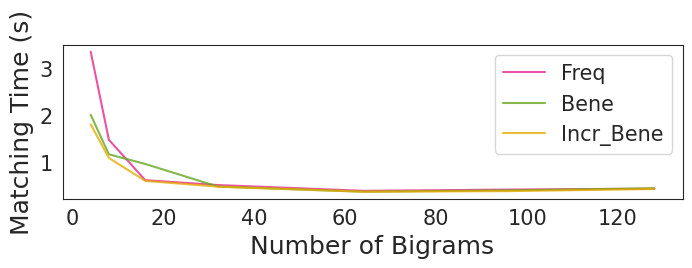

In [15]:
result_dir = 'result_subset'

freq_time = []
bene_time = []
incr_time = []
for num in x:
    perf_df = pd.read_csv(f'{result_dir}/microbench{num}/summary0.csv', sep='\t')
    freq_time.append(perf_df['mid_filter_time'].sum())
    bene_time.append(perf_df['mid_bene_filter_time'].sum())
    incr_time.append(perf_df['mid_incr_filter_time'].sum())

plot_dict = {
    'name': 'time_3method',
    'ylabel': 'Matching Time (s)',
    'label1': 'Freq',
    'data1': freq_time,
    'label2': 'Bene',
    'data2': bene_time,
    'label3': 'Incr_Bene',
    'data3': incr_time,
}
plot_line(x, plot_dict, color_shift=True)

In [16]:
zipped = list(zip(x, freq_time, bene_time, incr_time))

df_time = pd.DataFrame(zipped, columns=['Num-BiGram', 'Freq', 'Bene', 'Incr_Bene'])